In [58]:
import pandas as pd

# Load data
df = pd.read_csv("train_features.csv")

# Convert datetime if needed
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Drop row_id and prediction_unit_id
df = df.drop(columns=['row_id', 'prediction_unit_id'], errors='ignore')

# --- STEP 1: Aggregate consumption and production across all prosumers ---
df_targets = (
    df.groupby(['datetime', 'is_consumption'])['target']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={True: 'consumption', False: 'production'})
)

# --- STEP 2: Average all remaining features across each datetime ---
# We'll drop columns used in aggregation and those already in df_targets
exclude_cols = ['target', 'is_consumption', 'row_id', 'prediction_unit_id']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Group by datetime and take the mean of remaining features
# Only keep numeric columns (plus datetime for grouping)
numeric_cols = df[feature_cols].select_dtypes(include='number').columns.tolist()
df_features = df[['datetime'] + numeric_cols].groupby('datetime').mean().reset_index()

# --- STEP 3: Merge aggregated target data with average feature data ---
df_merged = pd.merge(df_targets, df_features, on='datetime', how='left')

# Done — df_merged now contains total consumption/production + average features
df_merged.head()

             datetime  production  consumption    county  is_business  \
0 2021-09-01 00:00:00       4.362    19859.808  7.393443     0.508197   
1 2021-09-01 01:00:00      11.852    19265.078  7.393443     0.508197   
2 2021-09-01 02:00:00       1.845    19260.892  7.393443     0.508197   
3 2021-09-01 03:00:00       1.517    19026.484  7.393443     0.508197   
4 2021-09-01 04:00:00       2.492    19367.124  7.393443     0.508197   

   product_type  data_block_id    year  quarter  month  ...  \
0           2.0            0.0  2021.0      3.0    9.0  ...   
1           2.0            0.0  2021.0      3.0    9.0  ...   
2           2.0            0.0  2021.0      3.0    9.0  ...   
3           2.0            0.0  2021.0      3.0    9.0  ...   
4           2.0            0.0  2021.0      3.0    9.0  ...   

   target_6_days_ago  target_7_days_ago  target_8_days_ago  target_9_days_ago  \
0                NaN                NaN                NaN                NaN   
1                NaN

In [61]:
start_time = df_agg['datetime'].min()
end_time = df_agg['datetime'].max()

print(f"Time range: {start_time} to {end_time}")

Time range: 2021-09-01 00:00:00 to 2023-05-31 23:00:00


In [2]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv("train_features.csv")

# Optionally convert datetime (if you'll use it elsewhere)
df['datetime'] = pd.to_datetime(df['datetime'], errors='ignore')

# Drop row_id and prediction_unit_id (not useful for grouping)
df = df.drop(columns=['row_id', 'prediction_unit_id'], errors='ignore')

# Define index columns — used for grouping/pivoting
pivot_index = [
    'datetime', 'county', 'is_business', 'product_type',
    'date', 'year', 'quarter', 'month', 'week', 'hour',
    'day_of_year', 'day_of_month', 'day_of_week'
]

# Split the dataset:
# 1. Just the columns we'll pivot
df_targets = df[pivot_index + ['target', 'is_consumption']]

# 2. All the other features (excluding 'target' and 'is_consumption')
df_features = df.drop(columns=['target', 'is_consumption'])

# Pivot to get consumption and production
df_pivoted = df_targets.pivot_table(
    index=pivot_index,
    columns='is_consumption',
    values='target'
).reset_index()

# Rename columns
df_pivoted.columns.name = None
df_pivoted = df_pivoted.rename(columns={True: 'consumption', False: 'production'})

# Merge the features back in using the same keys
df_merged = pd.merge(df_pivoted, df_features, on=pivot_index, how='left')

# Preview result
df_merged.head()

<ipython-input-2-18be5bb63173>:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['datetime'] = pd.to_datetime(df['datetime'], errors='ignore')


,datetime,county,is_business,product_type,date,year,quarter,month,week,hour,...,target_6_days_ago,target_7_days_ago,target_8_days_ago,target_9_days_ago,target_10_days_ago,target_11_days_ago,target_12_days_ago,target_13_days_ago,target_14_days_ago,target_15_days_ago
0,2021-09-01,0,0,1,2021-09-01,2021,3,9,35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-01,0,0,1,2021-09-01,2021,3,9,35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-01,0,0,2,2021-09-01,2021,3,9,35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-01,0,0,2,2021-09-01,2021,3,9,35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-01,0,0,3,2021-09-01,2021,3,9,35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_clean = df_merged.dropna()

# Drop non-numeric columns (like datetime, county, etc.)
df = df_clean.select_dtypes(include='number')

In [62]:
df_merged.isna().sum(axis=1).value_counts().sort_index().head()

,count
0,14892
1,82
2,24
3,24
4,24


In [7]:
df.columns

Index(['county', 'is_business', 'product_type', 'year', 'quarter', 'month',
       'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week',
       'production', 'consumption', 'data_block_id', 'eic_count_client',
       'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean',
       'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean',
       'cloudcover_total_h_mean', 'cloudcover_low_h_mean',
       'cloudcover_mid_h_mean', 'cloudcover_high_h_mean',
       'windspeed_10m_h_mean', 'winddirection_10m_h_mean',
       'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean',
       'diffuse_radiation_h_mean', 'hour_h', 'hours_ahead_f_mean',
       'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean',
       'cloudcover_low_f_mean', 'cloudcover_mid_f_mean',
       'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean',
       '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean',
       'surface_solar_radiation_downwards_f_mea

In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Sort by datetime (still important)
df['datetime'] = pd.to_datetime({
    'year': df['year'],
    'month': df['month'],
    'day': df['day_of_month'],
    'hour': df['hour']
})
df = df.sort_values(by='datetime')

# Compute imbalance
df['imbalance'] = df['production'] - df['consumption']

# Lagged imbalance (AR(1) component)
df['imbalance_lag1'] = df['imbalance'].shift(1)

# Forecast errors (feel free to add more)
df['solar_error'] = df['direct_solar_radiation_f_mean'] - df['shortwave_radiation_h_mean']
df['cloud_error'] = df['cloudcover_total_f_mean'] - df['cloudcover_total_h_mean']
df['temp_error'] = df['temperature_f_mean'] - df['temperature_h_mean']

# Drop missing values due to shift
df_model = df[['imbalance', 'imbalance_lag1', 'solar_error', 'cloud_error', 'temp_error']].dropna()

# Set up and fit model
X = df_model[['imbalance_lag1', 'solar_error', 'cloud_error', 'temp_error']]
y = df_model['imbalance']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Show results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              imbalance   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     164.2
Date:                Sun, 13 Apr 2025   Prob (F-statistic):          2.48e-138
Time:                        22:39:47   Log-Likelihood:            -1.4942e+05
No. Observations:               18069   AIC:                         2.988e+05
Df Residuals:                   18064   BIC:                         2.989e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -254.9194     17.163    -14.

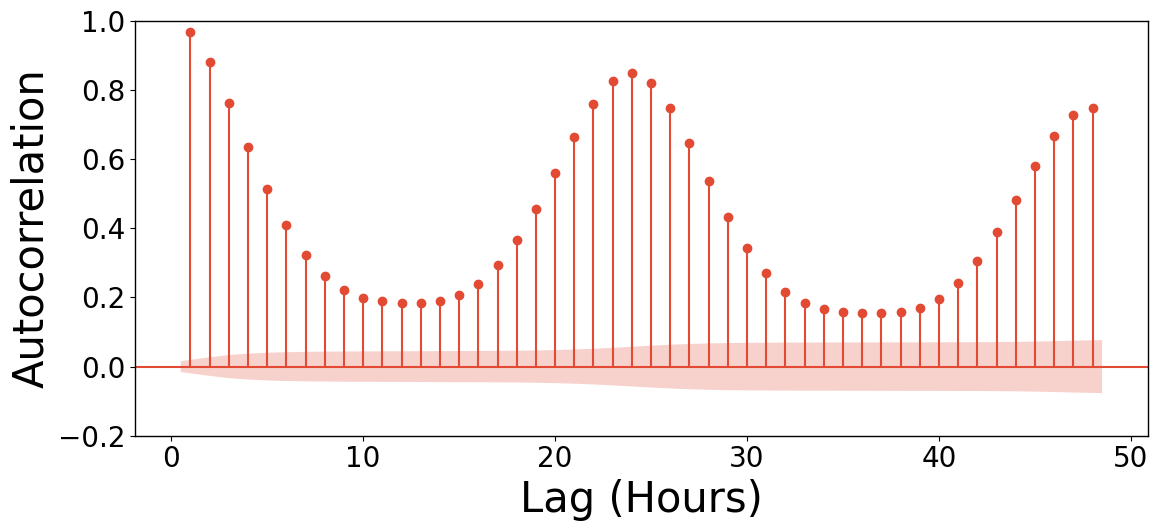

In [73]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (19, 11)
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams['font.family'] = 'sans-serif'  # Options: 'serif', 'sans-serif', 'monospace', etc.
plt.rcParams["axes.labelcolor"] = 'black'
plt.rcParams["axes.linewidth"] = 1

# Compute imbalance and sort if not already
df_merged['imbalance'] = df_merged['production'] - df_merged['consumption']
df_merged = df_merged.sort_values(by='datetime')

# Create ACF plot object
fig, ax = plt.subplots(figsize=(12, 6))

# Generate ACF plot with red lags and nice style
plot_acf(df_merged['imbalance'].dropna(), lags=48, ax=ax, alpha=0.05, zero=False)

# Customize plot aesthetics
for line in ax.lines[1:]:  # first two are confidence bounds
    # line.set_color('red')
    line.set_marker('o')
    line.set_markersize(6)

ax.set_xlabel("Lag (Hours)", fontsize=30)
ax.set_ylabel("Autocorrelation", fontsize=30)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_ylim(-0.2, 1.0)
ax.set_facecolor("white")
fig.tight_layout()
plt.title("")
plt.show()

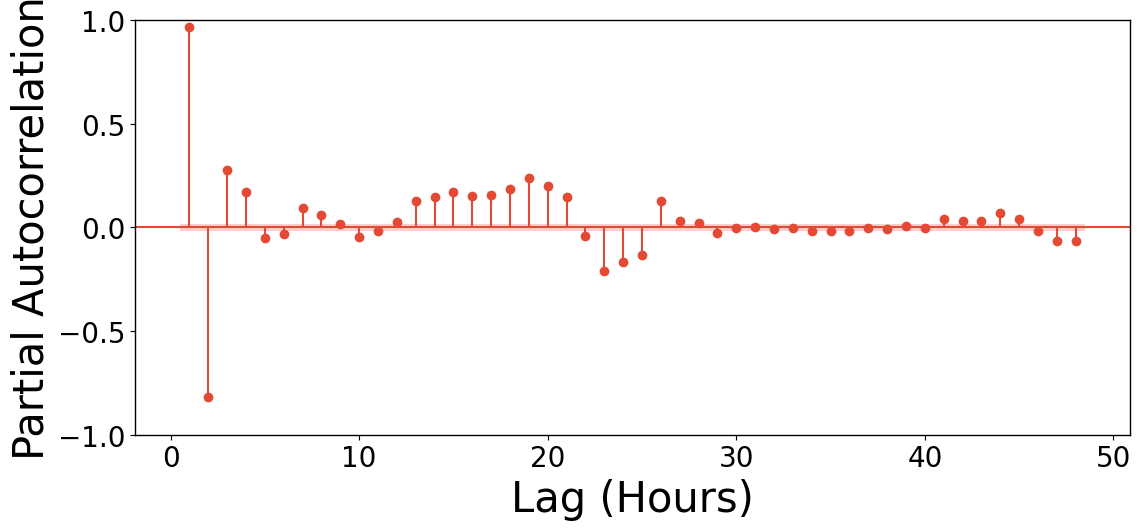

In [82]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (19, 11)
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams['font.family'] = 'sans-serif'  # Options: 'serif', 'sans-serif', 'monospace', etc.
plt.rcParams["axes.labelcolor"] = 'black'
plt.rcParams["axes.linewidth"] = 1

# Compute imbalance and sort if not already
df_merged['imbalance'] = df_merged['production'] - df_merged['consumption']
df_merged = df_merged.sort_values(by='datetime')

# Create ACF plot object
fig, ax = plt.subplots(figsize=(12, 6))

# Generate ACF plot with red lags and nice style
plot_pacf(df_merged['imbalance'].dropna(), lags=48, ax=ax, alpha=0.05, zero=False)

# Customize plot aesthetics
for line in ax.lines[1:]:  # first two are confidence bounds
    # line.set_color('red')
    line.set_marker('o')
    line.set_markersize(6)

ax.set_xlabel("Lag (Hours)", fontsize=30)
ax.set_ylabel("Partial Autocorrelation", fontsize=30)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_ylim(-1, 1.0)
ax.set_facecolor("white")
fig.tight_layout()
plt.title("")
plt.show()

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure datetime order
df_merged = df_merged.sort_values(by='datetime')

# Compute imbalance and exogenous variables
df_merged['imbalance'] = np.abs(df_merged['production'] - df_merged['consumption'])
df_merged['solar_error'] = df_merged['direct_solar_radiation_f_mean'] - df_merged['shortwave_radiation_h_mean']
df_merged['cloud_error'] = df_merged['cloudcover_total_f_mean'] - df_merged['cloudcover_total_h_mean']
df_merged['temp_error'] = df_merged['temperature_f_mean'] - df_merged['temperature_h_mean']

# Drop NA values
df_model = df_merged[['imbalance', 'solar_error', 'cloud_error', 'temp_error']].dropna()

# Define y and X
y = df_model['imbalance']
X = df_model[['solar_error', 'cloud_error', 'temp_error']]

# Fit ARIMAX: (p,d,q) = (1, 0, 1)
model = SARIMAX(y, exog=X, order=(2, 0, 2), seasonal_order=(2, 0, 2, 24))
results = model.fit(disp=False)

# Summary
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                          imbalance   No. Observations:                15273
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood             -151353.399
Date:                            Mon, 14 Apr 2025   AIC                         302730.799
Time:                                    03:35:39   BIC                         302822.405
Sample:                                         0   HQIC                        302761.166
                                          - 15273                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
solar_error   -50.3300      0.816    -61.663      0.000     -51.930     -48.730
cloud_error  -336.3716      1.80

In [98]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_model['imbalance'].dropna())
print(f"ADF p-value: {result[1]}")

ADF p-value: 4.451997908637172e-09


In [54]:
df["datetime"]

,datetime
43920,2021-09-16 00:00:00
43921,2021-09-16 00:00:00
43922,2021-09-16 00:00:00
43923,2021-09-16 00:00:00
43924,2021-09-16 00:00:00
...,...
62285,2021-09-22 06:00:00
62286,2021-09-22 06:00:00
62287,2021-09-22 06:00:00
62288,2021-09-22 06:00:00


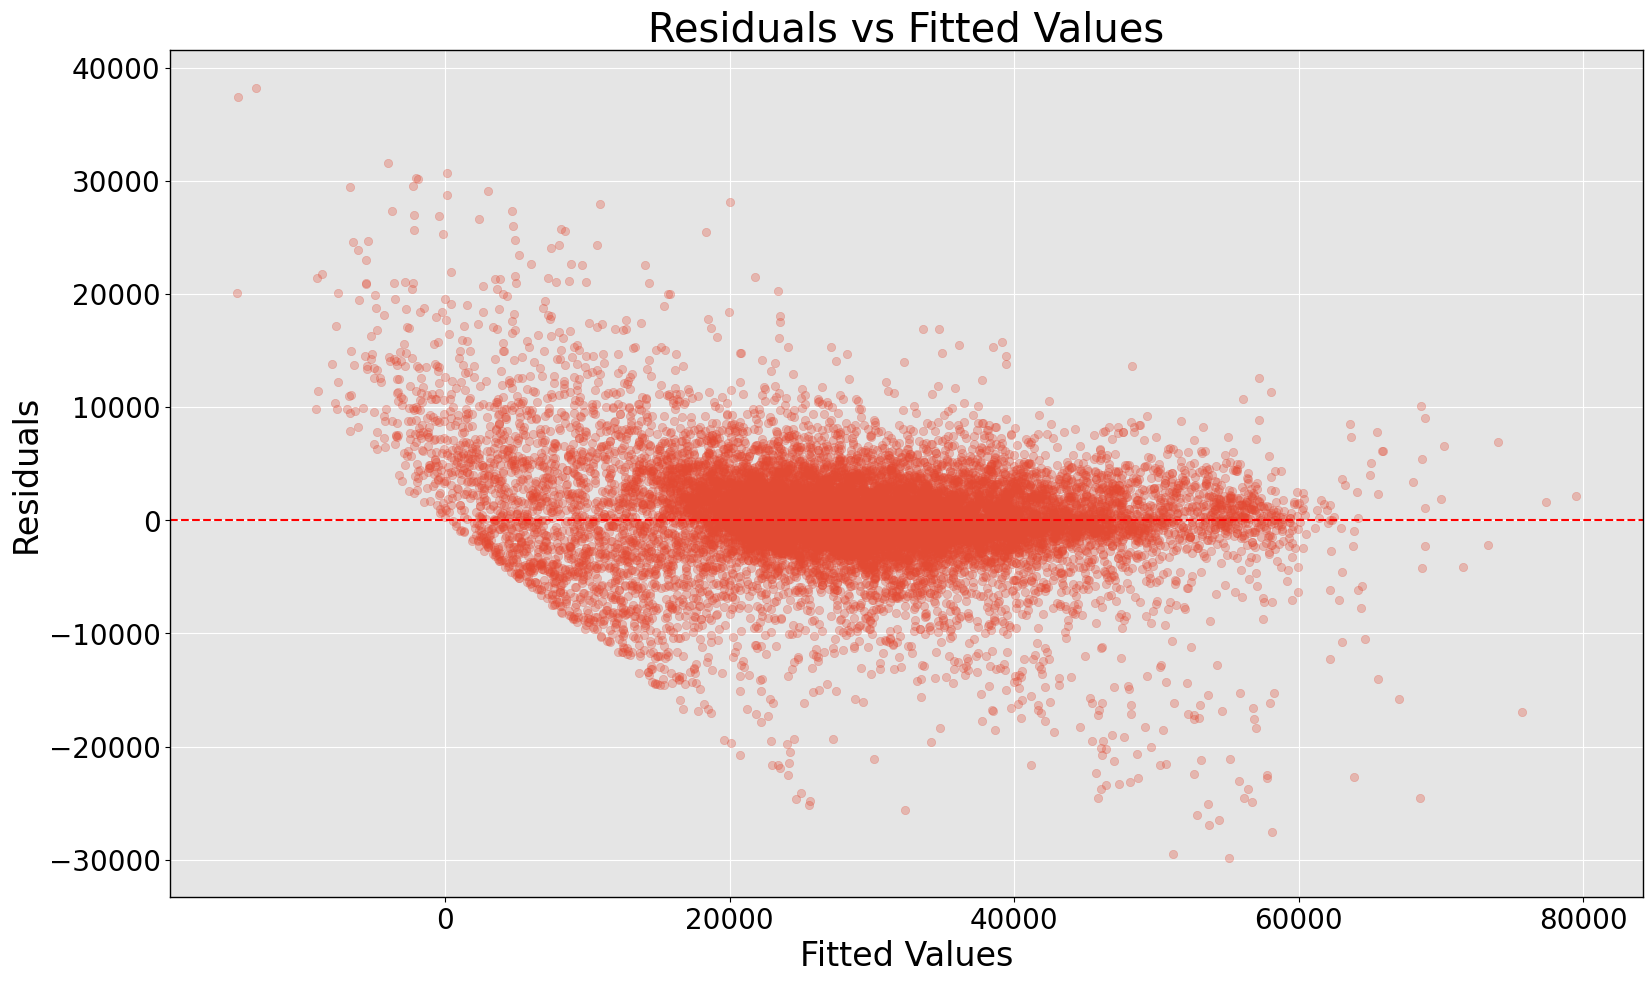

In [99]:
import matplotlib.pyplot as plt

plt.scatter(results.fittedvalues, results.resid, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(True)
plt.show()

In [100]:
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(results.resid)
print(f"ARCH test p-value: {arch_test[1]}")

ARCH test p-value: 2.487243674959405e-50


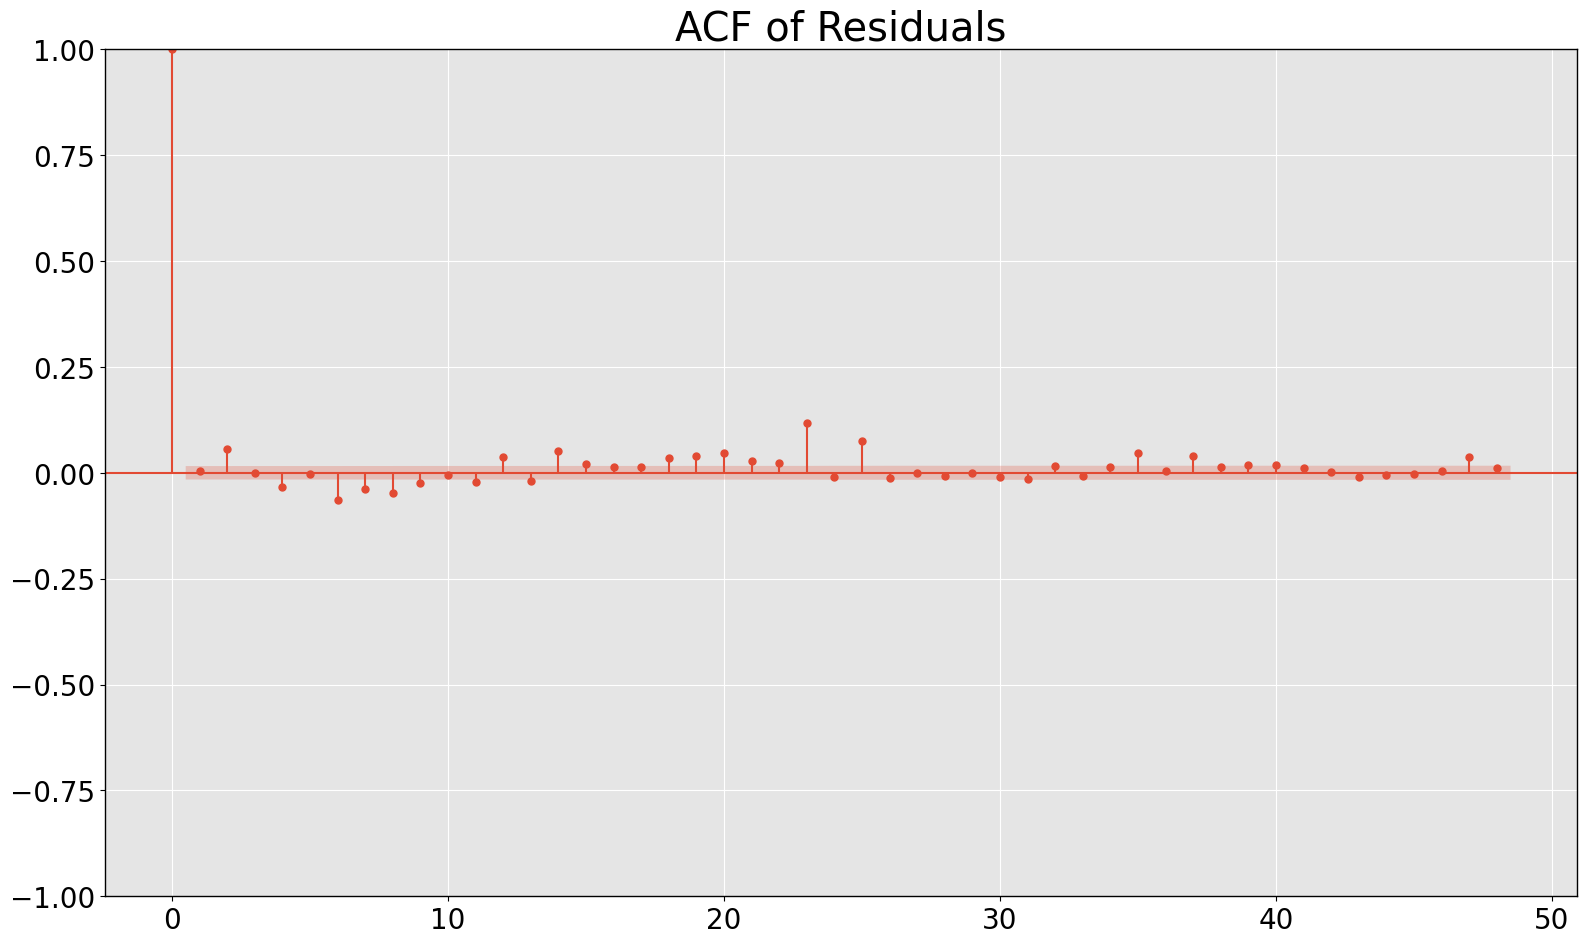

In [101]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(results.resid, lags=48)
plt.title("ACF of Residuals")
plt.show()

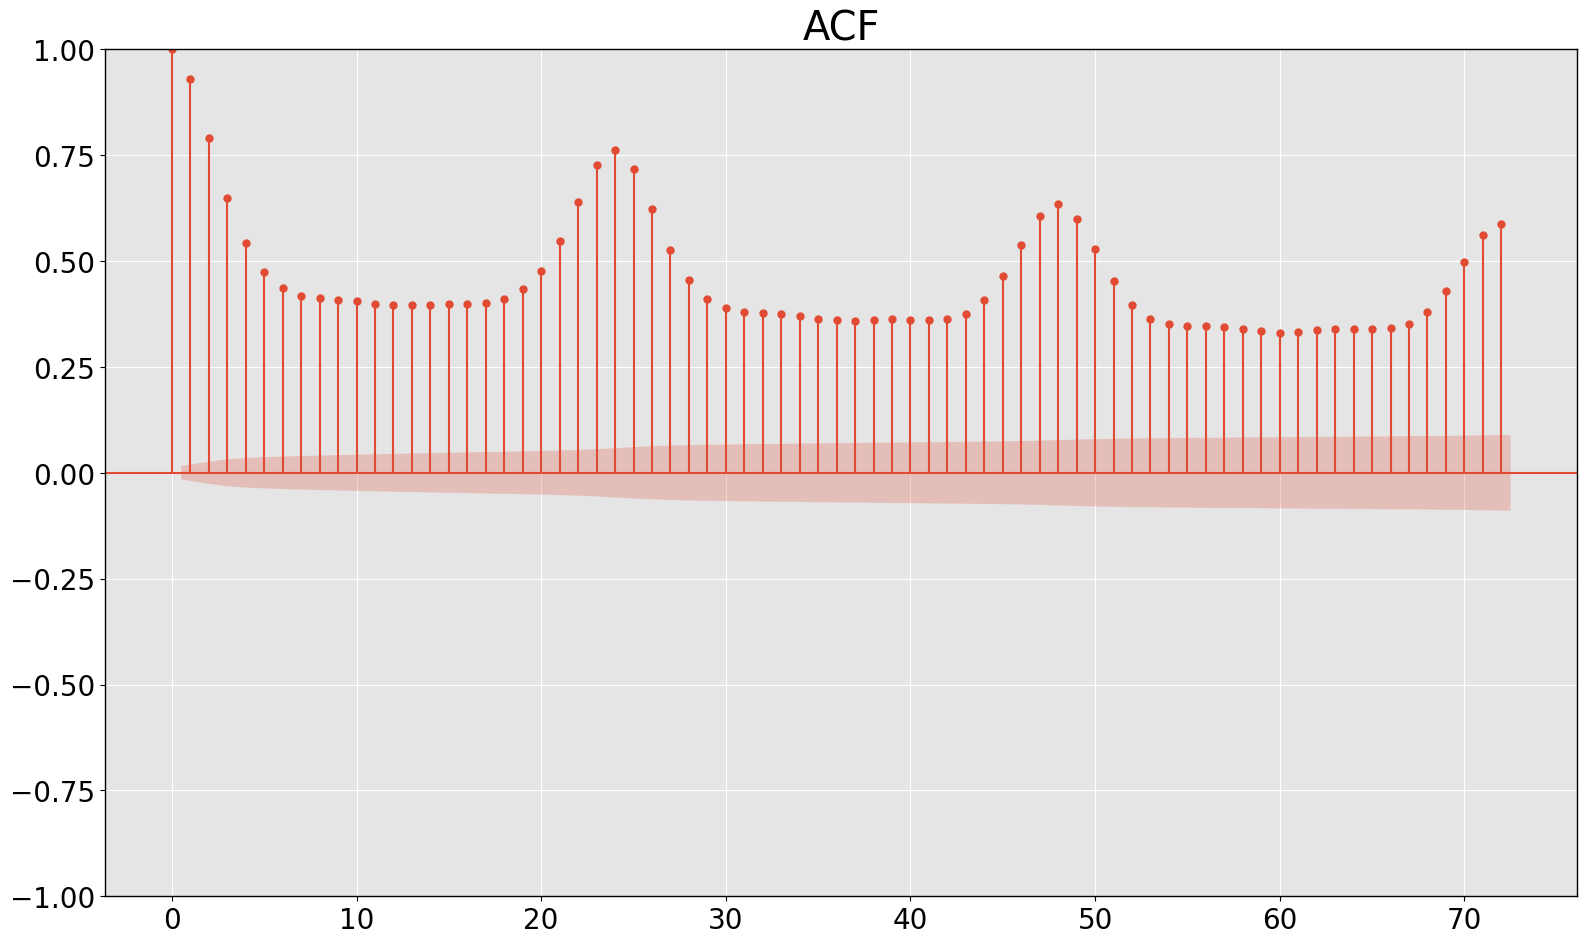

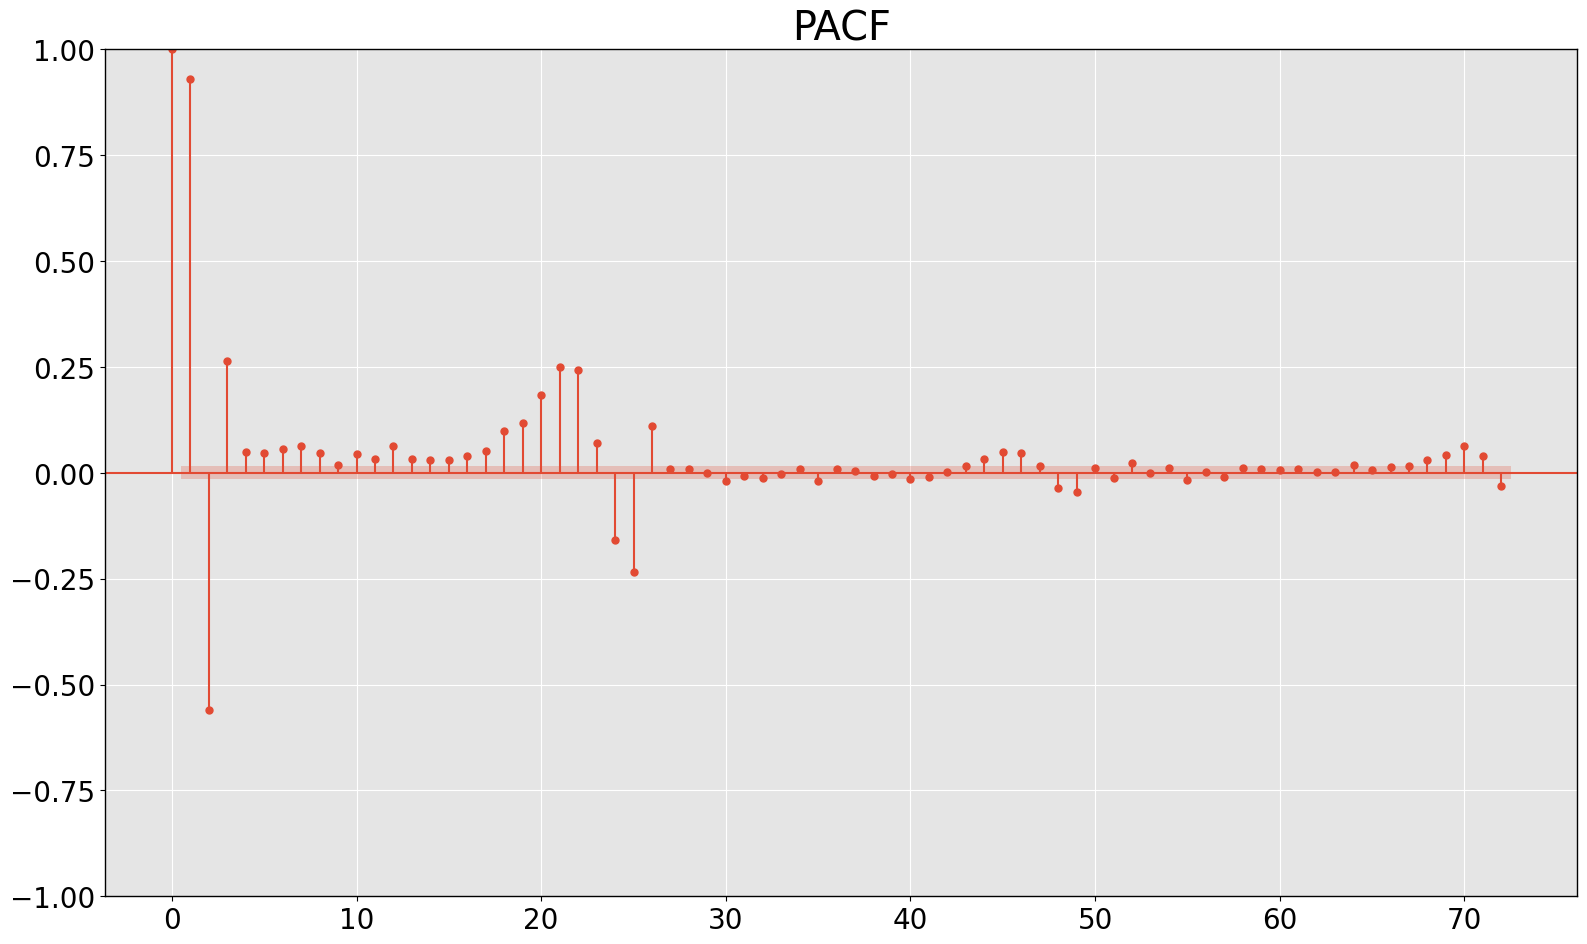

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF plot for q (MA)
plot_acf(df_model['imbalance'].dropna(), lags=72)
plt.title("ACF")
plt.show()

# PACF plot for p (AR)
plot_pacf(df_model['imbalance'].dropna(), lags=72)
plt.title("PACF")
plt.show()

In [103]:
df_model.head()

,imbalance,solar_error,cloud_error,temp_error
24,18926.416,-2.486111,-54.359518,-2.211255
25,18276.553,-1.583333,-48.596661,-2.433126
26,18309.418,-0.722222,-41.260950,-2.534991
27,18013.186,-0.145833,-41.614397,-2.553976
28,18231.099,0.000000,-35.861831,-2.575715
